# Real time Twitter Sentiment Analysis with PySpark

## Install required packages and libraries

In [1]:
!pip install pyspark
#!pip install kaggle
#!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


## Import the required packages and libraries

In [2]:
import pyspark
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

## Start the Spark session 

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()
spark

## Loading the data in Spark Dataframe

In [4]:
df = spark.read.csv("training.1600000.processed.noemoticon.csv", inferSchema=True)

In [5]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Renaming the columns

In [6]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

#### Checking the Schema

In [7]:
df.printSchema() 

root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



## Inspect and Preprocessing the Dataset

In [8]:
df.head(5)

[Row(target=0, id=1467810369, date='Mon Apr 06 22:19:45 PDT 2009', flag='NO_QUERY', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(target=0, id=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, id=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, id=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, id=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because

In [9]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


#### Check for missing values!!

In [10]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,target,id,date,flag,user,text
0,0,0,0,0,0,0


There are no missing values in the dataset.

#### Check for duplicates!!

In [11]:
df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


There are no duplicates in the dataset.

#### Check types of columns!!

In [12]:
df.dtypes

[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

#### Summary of the Dataframe

In [13]:
#df.summary().show()
#df.describe().show()

We only need the target and the text column for sentiment analyses, that's why dropping the rest of the columns.

In [14]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)

In [15]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [16]:
df.show(5, truncate = False)

+------+----------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                        |
+------+----------------------------------------------------------------------------------------------------------------------------+
|0     |At work                                                                                                                     |
|0     |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0     |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0     |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0     |really now, time for sleep. dreaming of my city, more 

In [17]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     0|
|     4|
+------+



There are only two distinct values in target column. O for "Negative" and 4 for "Positive" according to data description. Let's change the value of Positive from 4 to 1.

In [18]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.show(5, truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                        |
+-----+----------------------------------------------------------------------------------------------------------------------------+
|0.0  |At work                                                                                                                     |
|0.0  |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0.0  |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0.0  |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0.0  |really now, time for sleep. dreaming of my city, more tattoos,

In [19]:
df.tail(5)

[Row(label=Decimal('1.0'), text='Installing office to my little netbook, going to do some work at a friends house in a short while. '),
 Row(label=Decimal('1.0'), text='man.. Ab got work.. ahhh!!! but later imma shop till i drop!! '),
 Row(label=Decimal('1.0'), text="@paupaula I'm joining The SPectrum maybe. Idk... But yeah I'm dedicating myself to my studies too  How? Idk."),
 Row(label=Decimal('1.0'), text='Friend over  My god! 300th Update!!'),
 Row(label=Decimal('1.0'), text='TIME MAG ONLINE is very interesting. Watching videos this morning. Enjoying free content... while it lasts. ')]

In [20]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



## Text Preprocessing

#### Remove stopwords, punctuations, links, and stem the data

In [21]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [22]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Long\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def preprocess(text, stem=False):
    # Remove link, user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: total: 0 ns
Wall time: 74.2 ms


In [25]:
df.show()

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|            At work |                work|
|  0.0|@astewart87 oh my...|oh gosh made emot...|
|  0.0|i need new glasse...|need new glasses ...|
|  0.0|Getting changed i...|getting changed h...|
|  0.0|really now, time ...|really time sleep...|
|  0.0|pfff i want to go...|pfff want go back...|
|  0.0|Currently watchin...|currently watchin...|
|  0.0|What a bad day! N...|bad day need comf...|
|  0.0|Tried to install ...|tried install twi...|
|  0.0|Having casual, un...|casual unprotecte...|
|  0.0|Good morning worl...|good morning worl...|
|  0.0|@pmarnandus re: d...|daily gossip well...|
|  0.0|Someone somewhere...|someone somewhere...|
|  0.0|@weblivz What a b...|boot would demand...|
|  0.0|@jobeaz damn, sor...|damn sorry missed...|
|  0.0|@klariza that's a...|awesome love stuf...|
|  0.0|my tv husbands ri...|tv husbands rick ...|


In [26]:
df = df.drop("text")

## Displaying Word Cloud

In [27]:
from wordcloud import WordCloud

In [28]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text_cleaned
0,0.0,work
1,0.0,oh gosh made emotional haha idk dont want get old
2,0.0,need new glasses mines hangnon 1 arm
3,0.0,getting changed hopes means go store poor cat ...
4,0.0,really time sleep dreaming city tattoos great ...


#### Positive Sentiments Word Cloud

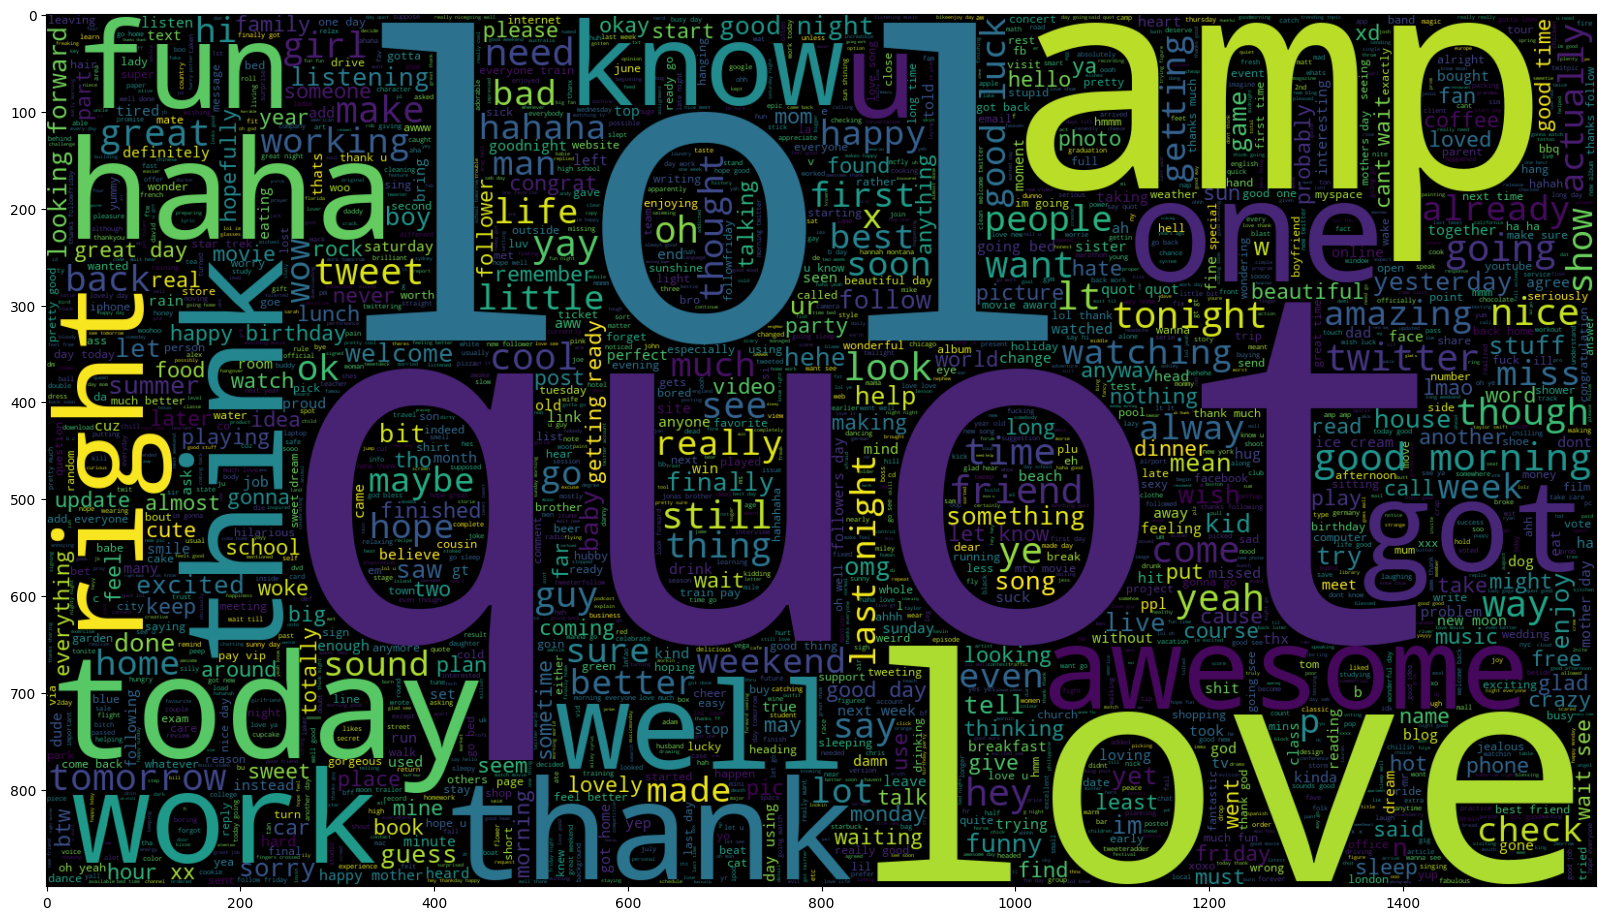

In [29]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Sentiments Word Cloud

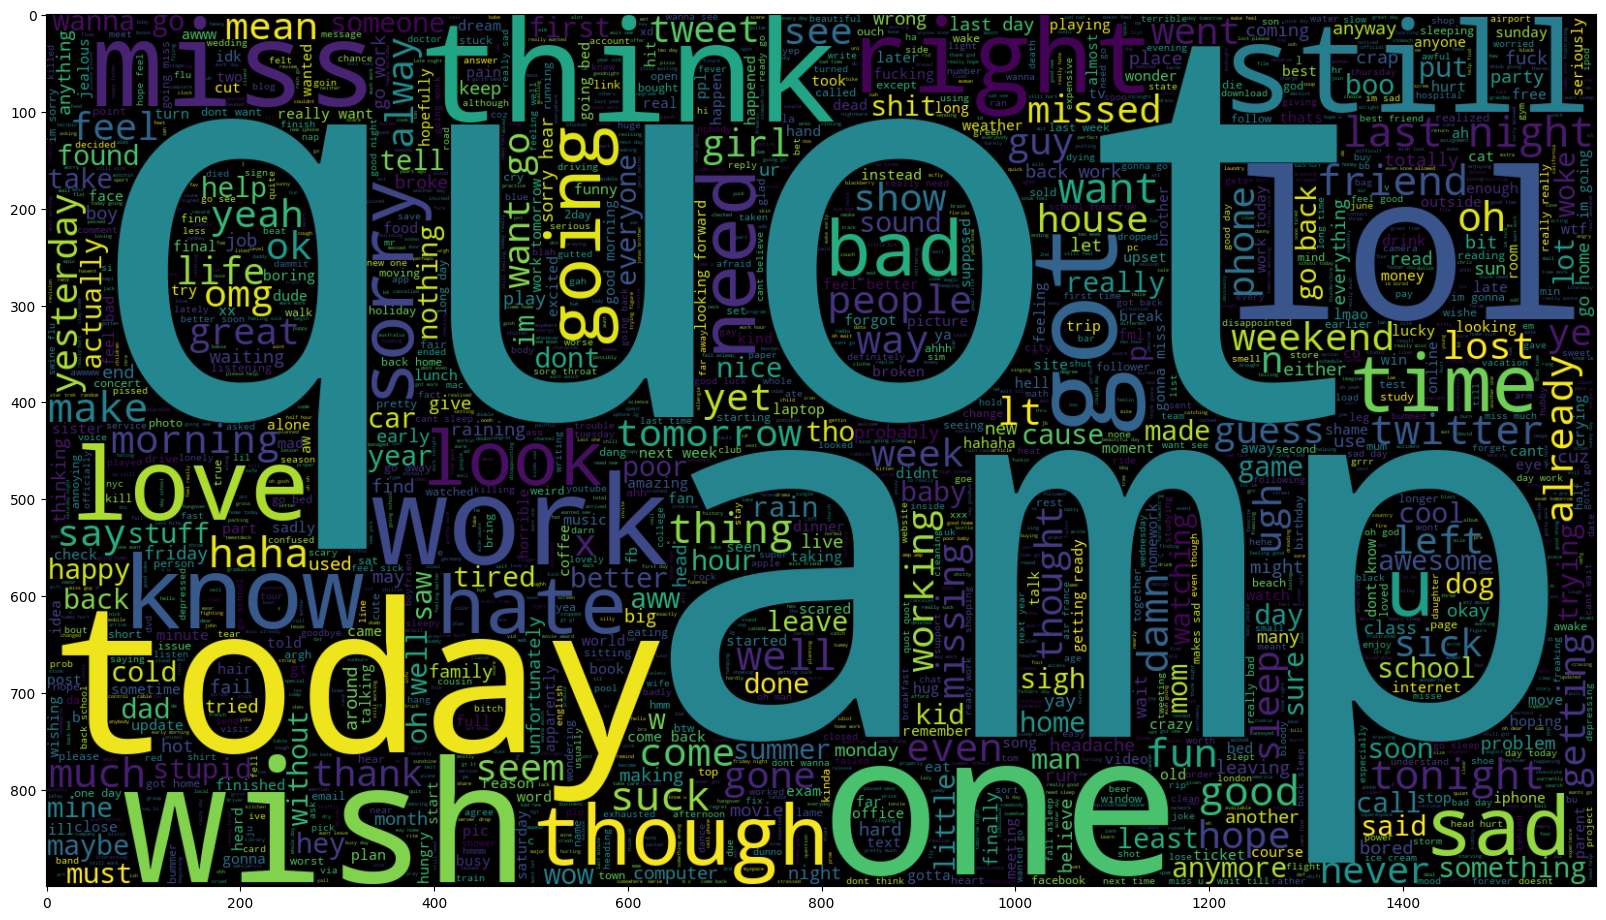

In [30]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Preparing Data for Model Building

#### Tokenizing the Text

In [31]:
from pyspark.ml.feature import Tokenizer

In [32]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show()

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|                work|              [work]|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|
|  0.0|need new glasses ...|[need, new, glass...|
|  0.0|getting changed h...|[getting, changed...|
|  0.0|really time sleep...|[really, time, sl...|
|  0.0|pfff want go back...|[pfff, want, go, ...|
|  0.0|currently watchin...|[currently, watch...|
|  0.0|bad day need comf...|[bad, day, need, ...|
|  0.0|tried install twi...|[tried, install, ...|
|  0.0|casual unprotecte...|[casual, unprotec...|
|  0.0|good morning worl...|[good, morning, w...|
|  0.0|daily gossip well...|[daily, gossip, w...|
|  0.0|someone somewhere...|[someone, somewhe...|
|  0.0|boot would demand...|[boot, would, dem...|
|  0.0|damn sorry missed...|[damn, sorry, mis...|
|  0.0|awesome love stuf...|[awesome, love, s...|
|  0.0|tv husbands rick ...|[tv, husbands, ri...|


#### Applying CountVectorizer

In [33]:
from pyspark.ml.feature import CountVectorizer

In [34]:
count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show()

+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+
|  0.0|                work|              [work]|  (262144,[7],[1.0])|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|(262144,[2,26,30,...|
|  0.0|need new glasses ...|[need, new, glass...|(262144,[25,33,10...|
|  0.0|getting changed h...|[getting, changed...|(262144,[4,56,235...|
|  0.0|really time sleep...|[really, time, sl...|(262144,[12,18,35...|
|  0.0|pfff want go back...|[pfff, want, go, ...|(262144,[4,6,13,2...|
|  0.0|currently watchin...|[currently, watch...|(262144,[5,32,61,...|
|  0.0|bad day need comf...|[bad, day, need, ...|(262144,[1,33,48,...|
|  0.0|tried install twi...|[tried, install, ...|(262144,[7,39,121...|
|  0.0|casual unprotecte...|[casual, unprotec...|(262144,[20,81,20...|
|  0.0|good morning worl...|[good, morning, w...|(262144,[0,10,35,...|
|  0.0

#### Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [35]:
from pyspark.ml.feature import IDF

In [36]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select("label", "features").show()  

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
|  0.0|(262144,[4,6,13,2...|
|  0.0|(262144,[5,32,61,...|
|  0.0|(262144,[1,33,48,...|
|  0.0|(262144,[7,39,121...|
|  0.0|(262144,[20,81,20...|
|  0.0|(262144,[0,10,35,...|
|  0.0|(262144,[24,39,40...|
|  0.0|(262144,[3,147,98...|
|  0.0|(262144,[15,49,29...|
|  0.0|(262144,[21,51,14...|
|  0.0|(262144,[8,31,78,...|
|  0.0|(262144,[66,201,3...|
|  0.0|(262144,[8,31,124...|
|  0.0|(262144,[157,256,...|
|  0.0|(262144,[176,317,...|
+-----+--------------------+
only showing top 20 rows



In [37]:
df_final = rescaledData.select("label", "features")

#### Splitting the data into training and test dataset

In [38]:
seed = 42  # set seed for reproducibility
trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [39]:
trainDF.count()

1120688

In [40]:
trainDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[5.81...|
|  0.0|(262144,[0,1],[2....|
|  0.0|(262144,[0,1,2,6,...|
+-----+--------------------+
only showing top 20 rows



In [41]:
trainDF.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|560337|
|  1.0|560351|
+-----+------+



In [42]:
testDF.count()

479312

## Training the Model

In [43]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
model = lr.fit(trainDF)
predictions = model.transform(testDF)
pred = predictions.toPandas()
pred.head()

,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.27117879740693135, 0.27117879740693135]","[0.43261772490919426, 0.5673822750908057]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.27117879740693135, 0.27117879740693135]","[0.43261772490919426, 0.5673822750908057]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.27117879740693135, 0.27117879740693135]","[0.43261772490919426, 0.5673822750908057]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.27117879740693135, 0.27117879740693135]","[0.43261772490919426, 0.5673822750908057]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.27117879740693135, 0.27117879740693135]","[0.43261772490919426, 0.5673822750908057]",1.0


## Evaluating the Model

In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of our Logistic Regression model is: 0.8170446400121436


#### Classification Report and Confusion Matrix

In [45]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [46]:
y_true.value_counts()

label
0.0    239663
1.0    239649
Name: count, dtype: int64

In [47]:
y_pred.value_counts()

prediction
1.0    247782
0.0    231530
Name: count, dtype: int64

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75    239663
         1.0       0.75      0.78      0.76    239649

    accuracy                           0.76    479312
   macro avg       0.76      0.76      0.76    479312
weighted avg       0.76      0.76      0.76    479312



<Axes: >

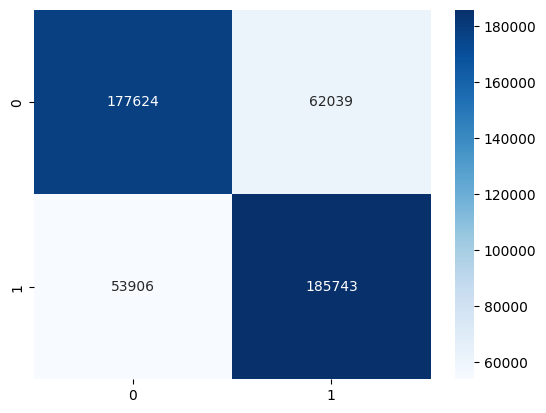

In [49]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')

## Saving the Models

In [50]:
idf.save("vectoriser-ngram-(1,2)")
lr.save("Sentiment-LR")